New attempt at trying to generate examples  - need to preprocess the grids to 6 color channels then dynamically run the heatmap function for each grid and then perform prediction as specified in evaluate

In [ ]:
import sys
#i needed to append my analysis path to system to access the bcos saved models
sys.path.append('/Users/toby/Interpretable-Deep-Fake-Detection/analysis')

from b_cos.resnet import resnet50
from b_cos.bcosconv2d import BcosConv2d

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torchvision import transforms, datasets
from tqdm import tqdm
from PIL import Image
import os
import numpy as np
import torch.nn.functional as F

## Grids
create grid has been updated to save pngs, the following code will call up those grids and preproccess them for 6 color channels and develop heatmaps on them

In [3]:
class MyToTensor(transforms.ToTensor):
    def __init__(self):
        """
        Same as transforms.ToTensor, except that if input to __call__ is already tensor, the input is returned unchanged
        """
        super().__init__()

    def __call__(self, input_img):
        if not isinstance(input_img, torch.Tensor):
            return super().__call__(input_img)
        return input_img

class AddInverse(nn.Module):
    def __init__(self, dim=1):
        """
            Adds (1-in_tensor) as additional channels to its input via torch.cat().
            Can be used for images to give all spatial locations the same sum over the channels to reduce color bias.
        """
        super().__init__()
        self.dim = dim

    def forward(self, in_tensor):
        out = torch.cat([in_tensor, 1-in_tensor], self.dim)
        return out
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize if necessary
    MyToTensor(),            # Converts image to tensor if not already
    AddInverse(dim=0),            # Adds the inverse channels
])

In [23]:
class CustomImageDataset(Dataset):
    def __init__(self, folder_paths, transform=None):
        """
        Args:
            folder_paths (dict): Dictionary where keys are folder paths, and values are the labels.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_files = []  # Store (image_path, label) tuples
        for fp, label in folder_paths.items():
            # List all subdirectories within the folder
            subfolders = [os.path.join(fp, d) for d in os.listdir(fp) if os.path.isdir(os.path.join(fp, d))]
        # Include images from the root directory as well as subfolders
        self.image_files.extend(
            [(os.path.join(fp, f), label) for f in os.listdir(fp) if f.endswith((".png", ".jpg"))]
        )

        for folder_path in subfolders:
            self.image_files.extend(
                [(os.path.join(folder_path, f), label) for f in os.listdir(folder_path) if f.endswith((".png", ".jpg"))]
            )
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, label = self.image_files[idx]  # Get image path and its label
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, img_path


file_path_deepfakebench = {'../../datasets/2x2_images': 1}

dataset = CustomImageDataset(file_path_deepfakebench, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for images, label, img_path in dataloader:
    print(f"Batch of images shape: {images.shape}")
    break

Batch of images shape: torch.Size([20, 6, 224, 224])


In [24]:
def to_numpy(tensor):
    """
    Converting tensor to numpy.
    Args:
        tensor: torch.Tensor

    Returns:
        Tensor converted to numpy.

    """
    if not isinstance(tensor, torch.Tensor):
        return tensor
    return tensor.detach().cpu().numpy()

def grad_to_img(img, linear_mapping, smooth=15, alpha_percentile=99.5):
    """
    Computing color image from dynamic linear mapping of B-cos models.
    Args:
        img: Original input image (encoded with 6 color channels)
        linear_mapping: linear mapping W_{1\rightarrow l} of the B-cos model
        smooth: kernel size for smoothing the alpha values
        alpha_percentile: cut-off percentile for the alpha value

    Returns:
        image explanation of the B-cos model
    """
    # shape of img and linmap is [C, H, W], summing over first dimension gives the contribution map per location
    contribs = (img * linear_mapping).sum(0, keepdim=True)
    contribs = contribs[0]
    # Normalise each pixel vector (r, g, b, 1-r, 1-g, 1-b) s.t. max entry is 1, maintaining direction
    rgb_grad = (linear_mapping / (linear_mapping.abs().max(0, keepdim=True)[0] + 1e-12))
    # clip off values below 0 (i.e., set negatively weighted channels to 0 weighting)
    rgb_grad = rgb_grad.clamp(0)
    # normalise s.t. each pair (e.g., r and 1-r) sums to 1 and only use resulting rgb values
    rgb_grad = to_numpy(rgb_grad[:3] / (rgb_grad[:3] + rgb_grad[3:]+1e-12))

    # Set alpha value to the strength (L2 norm) of each location's gradient
    alpha = (linear_mapping.norm(p=2, dim=0, keepdim=True))
    # Only show positive contributions
    alpha = torch.where(contribs[None] < 0, torch.zeros_like(alpha) + 1e-12, alpha)
    if smooth:
        alpha = F.avg_pool2d(alpha, smooth, stride=1, padding=(smooth-1)//2)
    alpha = to_numpy(alpha)
    alpha = (alpha / np.percentile(alpha, alpha_percentile)).clip(0, 1)

    rgb_grad = np.concatenate([rgb_grad, alpha], axis=0)
    # Reshaping to [H, W, C]
    grad_image = rgb_grad.transpose((1, 2, 0))
    return grad_image

## Evaluation
now lets evalute, we need:
1. image grid
2. heatmap grid
3. divide heatmap into 4 different sections and count white pixels 
    - here an issue arises because pixels that appear to be white are not 255, my solution is to set a threshold but we should see if there is a way to fix this or if the code has some mistake

In [ ]:
#example file name: grid_0_fake_1.png, heatmap_0_fake_1.png
def evaluate_heatmap(heatmap, white_pixel_threshold = 240):
    """
    Splits a heatmap into 4 square sections, counts the white pixels in each,
    and returns the index of the square with the least white pixels.
    
    Args:
        heatmap (numpy.ndarray): 2D numpy array representing the heatmap.
                                 White pixels are assumed to have the maximum value (255).
    
    Returns:
        int: Index of the square with the least white pixels (0, 1, 2, or 3).
    """
    # Convert NumPy array to PIL Image
    image = Image.fromarray(heatmap, 'RGB')

# Convert to grayscale
    grayscale_image = image.convert('L')

# Convert back to NumPy array if needed
    heatmap_gray = np.array(grayscale_image)
    
    # Check if the heatmap is square
    rows, cols = heatmap_gray.shape
    if rows != cols:
        raise ValueError("The heatmap must be square.")
    
    # Check divisibility by 2
    if rows % 2 != 0:
        raise ValueError("The heatmap dimensions must be divisible by 2.")
    
    # Split the heatmap into 4 sections
    half = rows // 2
    sections = [
        heatmap_gray[:half, :half],  # Top-left (0)
        heatmap_gray[:half, half:],  # Top-right (1)
        heatmap_gray[half:, :half],  # Bottom-left (2)
        heatmap_gray[half:, half:]   # Bottom-right (3)
    ]
    
    # Count white pixels in each section
    white_pixel_counts = [np.sum(section >= white_pixel_threshold) for section in sections]
    
    # Find the index of the section with the least white pixels
    least_white_index = np.argmin(white_pixel_counts)
    
    return least_white_index

Batch of images shape: torch.Size([20, 6, 224, 224])


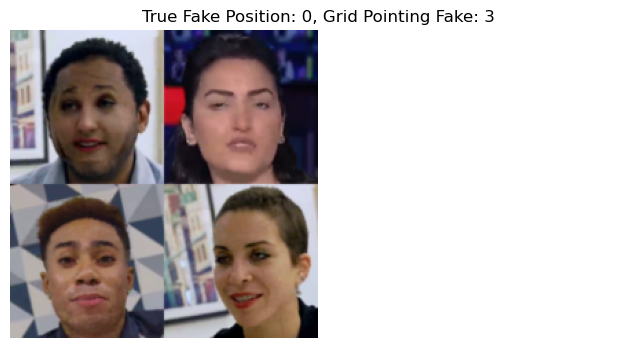

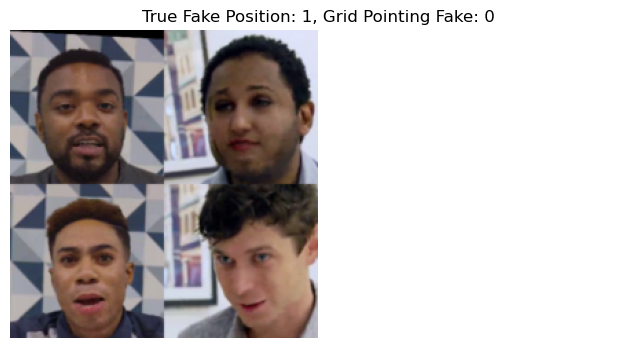

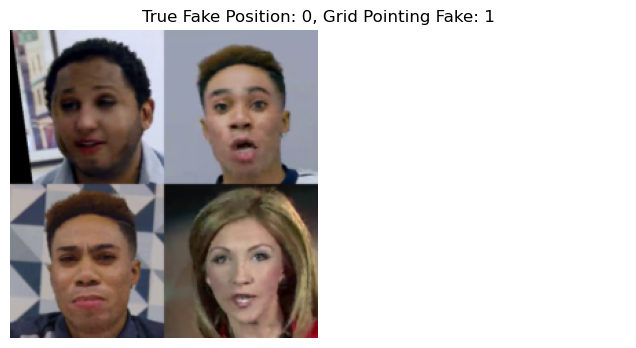

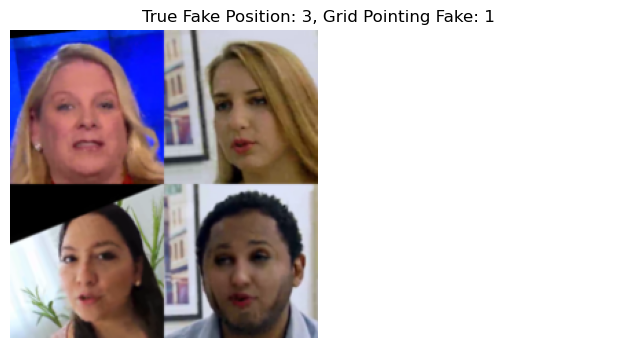

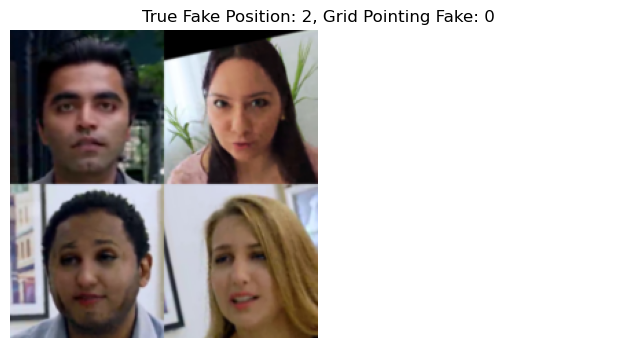

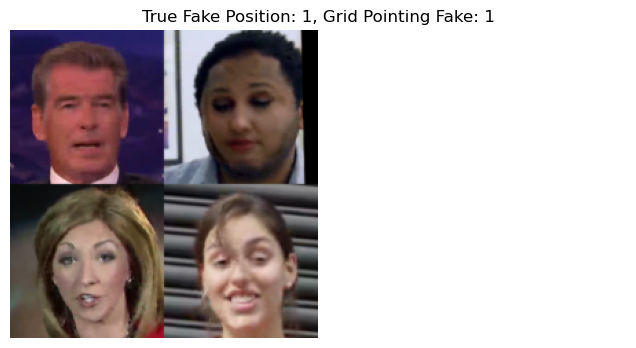

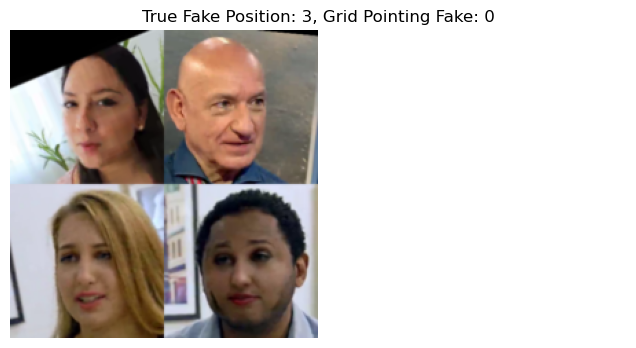

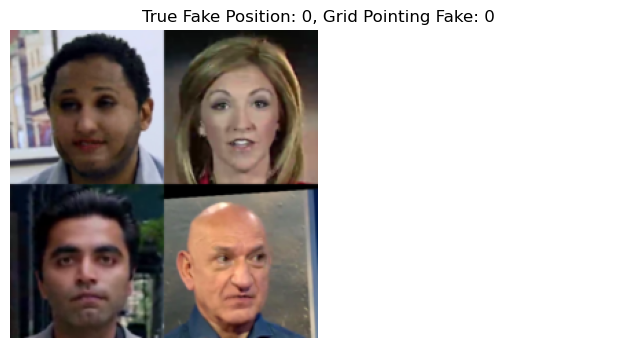

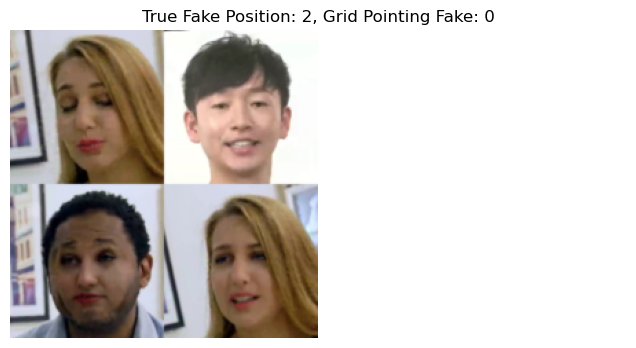

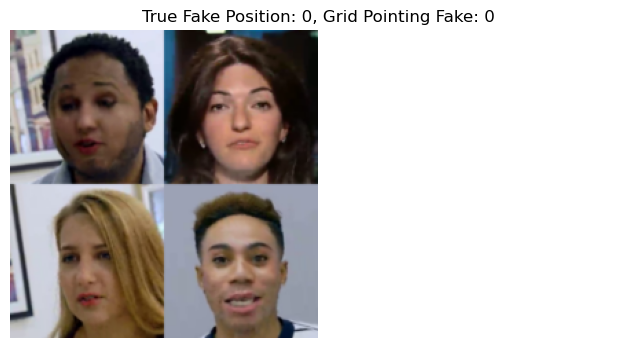

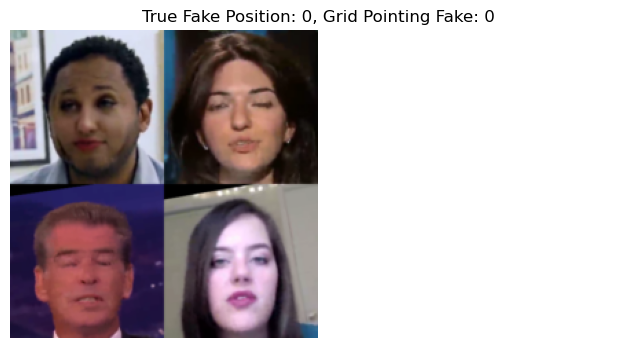

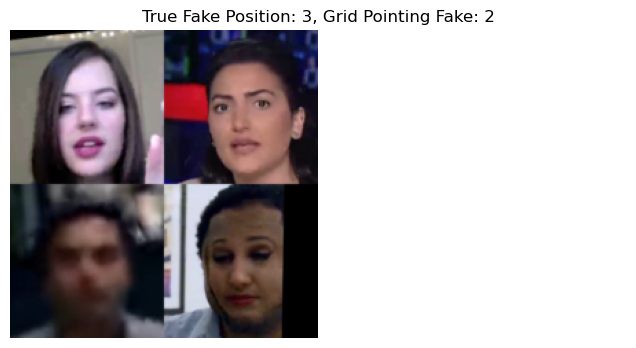

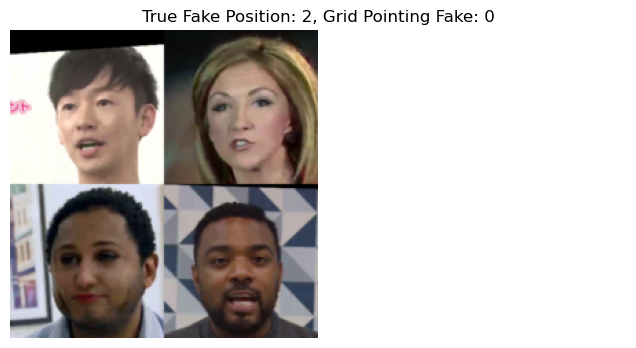

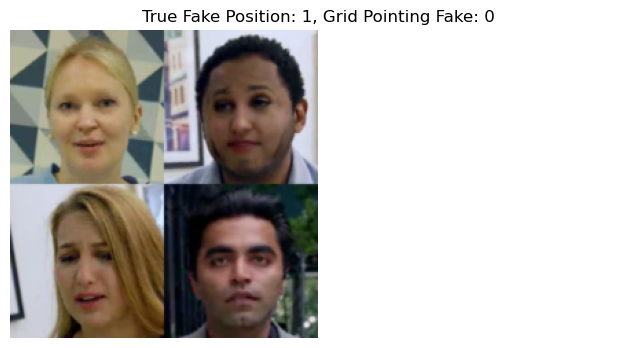

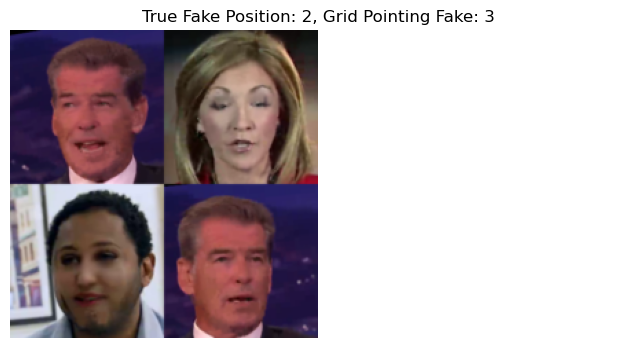

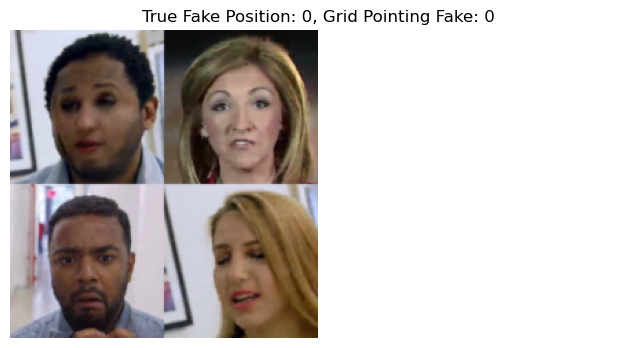

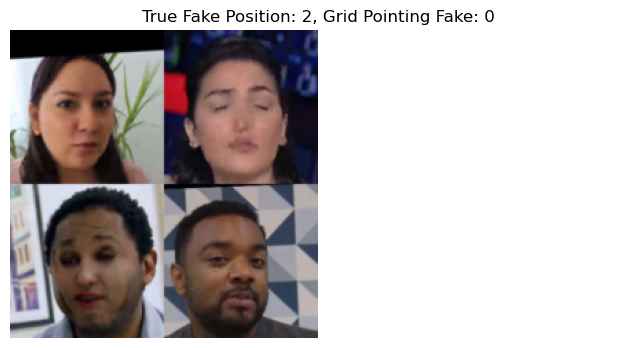

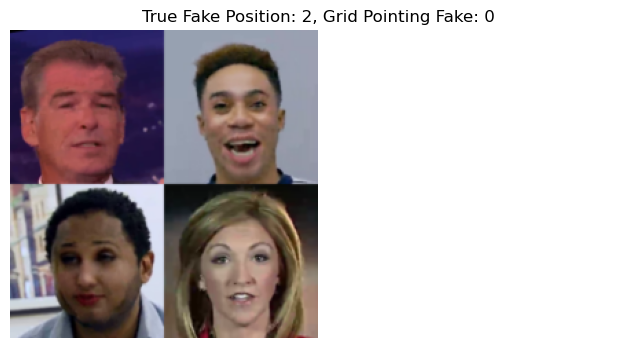

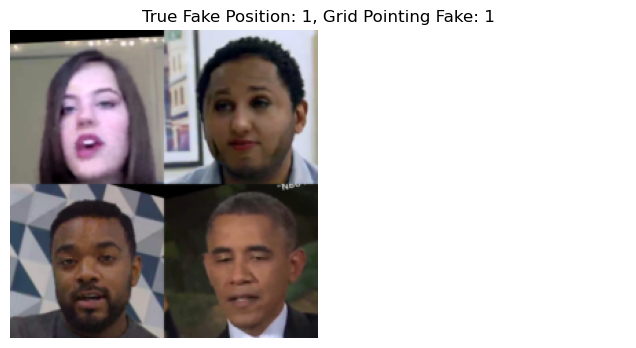

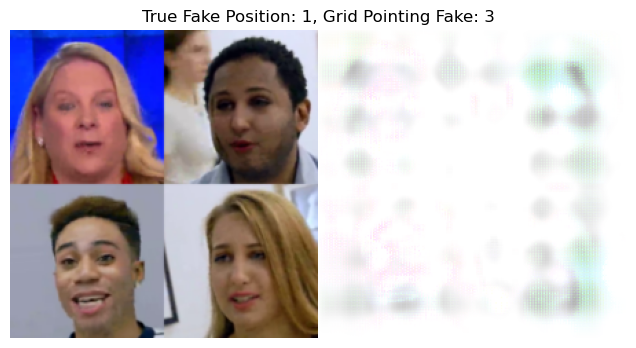

In [60]:
state_dict = "../../weights/B_cos/ResNet50/b_cos_model_1732594597.04.pth"
state_dict = "../../weights/B_cos/ResNet50/b_cos_model_1732303731.35.pth"
try:
    model = resnet50(pretrained=False, progress=True, num_classes=1, groups=32, width_per_group=4)
    model.load_state_dict(torch.load(state_dict, map_location="cpu"))
    
    # Set device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for img_batch, label_batch, path_batch in dataloader:
        print(f"Batch of images shape: {img_batch.shape}")

        # Iterate through the first 5 images in the batch
        num_images = min(len(img_batch), 20)
        for i in range(num_images):
            img = img_batch[i].unsqueeze(0).to(device)  # Process a single image
            label = label_batch[i]
            img_path = path_batch[i]
            img = img.requires_grad_(True)

            model.zero_grad()
            out = model(img)
            out.backward()

            # Generate attention visualization
            att = grad_to_img(img[0], img.grad[0], alpha_percentile=100, smooth=5)
            att[..., -1] *= to_numpy(out.sigmoid())

            # Prepare the image and attention map for visualization
            att = to_numpy(att)
            img_np = np.array(to_numpy(img[0, :3].permute(1, 2, 0)) * 255, dtype=np.uint8)
            
            #true fake position
            true_fake_pos = int(img_path.split('_fake_')[1].split('.')[0])

            # Plot the results
            fig, ax = plt.subplots(1, figsize=(8, 4))
            plt.imshow(img_np, extent=(0, 224, 0, 224))
            plt.imshow(att, extent=(224, 2 * 224, 0, 224))
            plt.xlim(0, 2 * 224)
            plt.xticks([])
            plt.yticks([])
            plt.title(f"True Fake Position: {true_fake_pos}, Grid Pointing Fake: {evaluate_heatmap(att)}")
            for spine in ax.spines.values():
                spine.set_visible(False)
            plt.show()
        break  # Exit after processing the first batch
except Exception as e:
    print(e)